In [ ]:
!pip install kagglehub[pandas-datasets]

# Importing the dataset to local enviornment from Kaggle

In [ ]:
# Install dependencies as needed:
# Pasted from kaggle

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "spotify_churn_dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "nabihazahid/spotify-dataset-for-churn-analysis",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:")
df.head()

/tmp/ipython-input-347681709.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 382k/382k [00:00<00:00, 458kB/s]


First 5 records:


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


# Importing the packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, classification_report


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


In [ ]:
df.describe()

,user_id,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4000.50000,37.662125,154.068250,50.127250,0.300127,6.943875,0.747750,0.258875
std,2309.54541,12.740359,84.015596,28.449762,0.173594,13.617953,0.434331,0.438044
min,1.00000,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.75000,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000,0.000000
50%,4000.50000,38.000000,154.000000,50.000000,0.300000,0.000000,1.000000,0.000000
75%,6000.25000,49.000000,227.000000,75.000000,0.450000,5.000000,1.000000,1.000000
max,8000.00000,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000,1.000000


In [ ]:
# our classification label
df['is_churned'].value_counts()

,count
is_churned,
0,5929
1,2071


In [ ]:
# preprocessing the data for correlation matrix
corr_df = df.copy()
# one hot encoding categorical columns
cat_cols = ['country', 'device_type','subscription_type']

# 1️⃣ Create dummies for those columns
dummy = pd.get_dummies(corr_df[cat_cols], drop_first=False).astype(int)

# 2️⃣ Concatenate them back with the original df
corr_df = pd.concat([corr_df, dummy], axis=1)

# 3️⃣ Drop the original categorical columns
corr_df = corr_df.drop(cat_cols, axis=1)

corr_df.sample(5)

,user_id,gender,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned,country_AU,...,country_PK,country_UK,country_US,device_type_Desktop,device_type_Mobile,device_type_Web,subscription_type_Family,subscription_type_Free,subscription_type_Premium,subscription_type_Student
1167,1168,Male,34,242,28,0.43,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
4238,4239,Female,31,13,70,0.34,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2705,2706,Other,26,94,57,0.55,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2594,2595,Other,52,296,32,0.24,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
1462,1463,Male,59,34,85,0.30,0,1,1,0,...,0,0,0,0,0,1,1,0,0,0


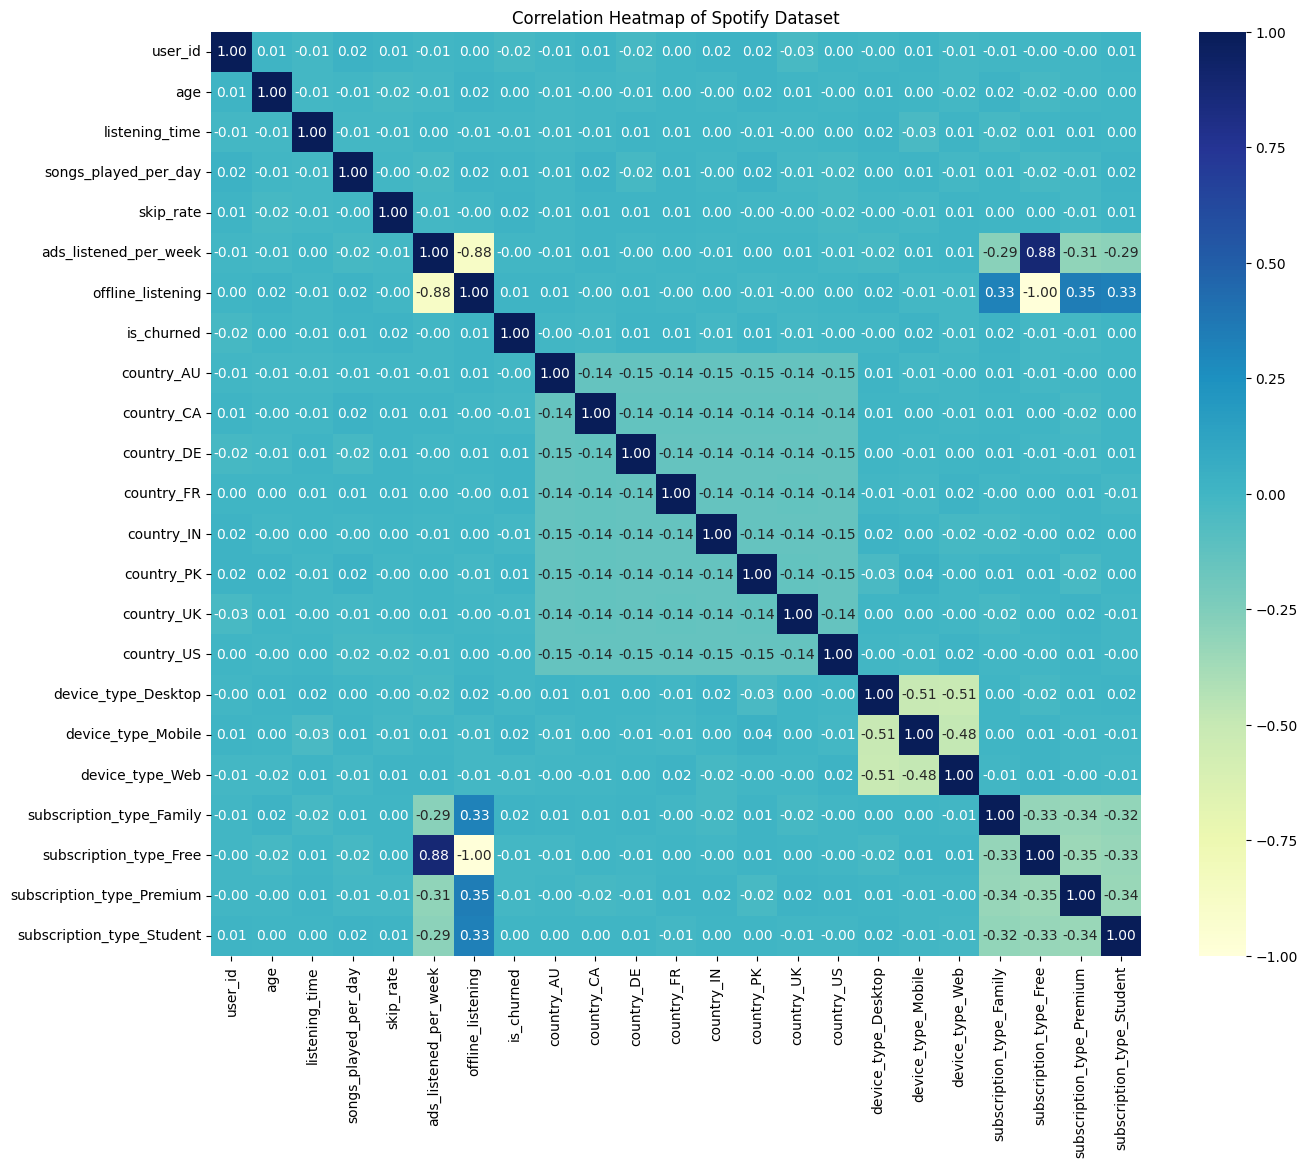

In [ ]:
correlation_matrix = corr_df.corr(numeric_only=True)
plt.figure(figsize = (15, 12))
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True, fmt=".2f")

plt.title('Correlation Heatmap of Spotify Dataset')
plt.show()

# Clustering

Churn rate per cluster:
Clusters
0    0.262120
1    0.249257
Name: is_churned, dtype: float64

Number of users per cluster:
Clusters
0    5982
1    2018
Name: count, dtype: int64


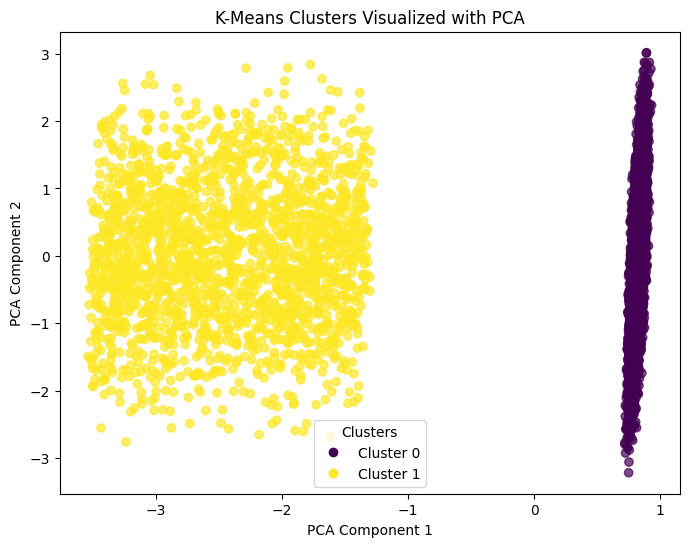

In [ ]:
labelCol = "is_churned"
labels = df[labelCol]
X = df.drop(columns=[labelCol])
# This sets aside the label so that it won't be used in the kmeans clustering.

numericCols = X.select_dtypes(include=['int64', 'float64']).columns
categoricalCols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=
    [
        ('num', StandardScaler(), numericCols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalCols)
    ]
)

#StandardScaler evens out the numeric features so that no single feature dominates due to scale.
#OneHotEncoder convers categorical features into binary vectors so that they can be used in clustering.

kmeans = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("cluster", KMeans(n_clusters=2, random_state=5))
    #2 Clusters (churned vs not churned)
    #Random seed set to 5
])

kmeans.fit(X)

clusters = kmeans.predict(X)
df["Clusters"] = clusters
clusterSummary = df.groupby("Clusters")[labelCol].mean()
clusterCounts = df["Clusters"].value_counts()

print("Churn rate per cluster:")
print(clusterSummary)

print("\nNumber of users per cluster:")
print(clusterCounts)

X_preprocessed = kmeans.named_steps["preprocess"].transform(X)

pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(8, 6))
# Scatter plot with cluster labels
scatter = plt.scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=clusters,
    cmap="viridis",
    alpha=0.7
)

# Create legend mapping cluster numbers to colors
legend_labels = ["Cluster 0", "Cluster 1"]
legend_handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=scatter.cmap(scatter.norm(i)))
    for i in range(len(legend_labels))
]

plt.legend(legend_handles, legend_labels, title="Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters Visualized with PCA")
plt.show()

Churn rate per cluster:
Clusters
0    0.262120
1    0.249257
Name: is_churned, dtype: float64

Number of users per cluster:
Clusters
0    5982
1    2018
Name: count, dtype: int64


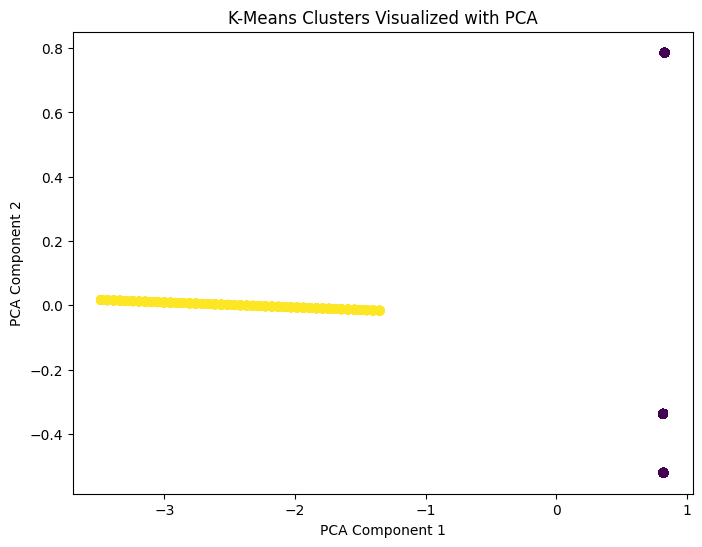

In [ ]:
# KMeans with specific columns

labelCol = "is_churned"
labels = df[labelCol]
X = df[['subscription_type', 'ads_listened_per_week', 'offline_listening']]
# This sets aside the label so that it won't be used in the kmeans clustering.
# Ran tests with many different column combinations

numericCols = X.select_dtypes(include=['int64', 'float64']).columns
categoricalCols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=
    [
        ('num', StandardScaler(), numericCols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalCols)
    ]
)

#StandardScaler evens out the numeric features so that no single feature dominates due to scale.
#OneHotEncoder convers categorical features into binary vectors so that they can be used in clustering.

kmeans = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("cluster", KMeans(n_clusters=2, random_state=5))
    #2 Clusters (churned vs not churned)
    #Random seed set to 5
])

kmeans.fit(X)

clusters = kmeans.predict(X)
df["Clusters"] = clusters
clusterSummary = df.groupby("Clusters")[labelCol].mean()
clusterCounts = df["Clusters"].value_counts()

print("Churn rate per cluster:")
print(clusterSummary)

print("\nNumber of users per cluster:")
print(clusterCounts)

#print(f"NaN values: {df.isnull().sum().sum()}")
#print(f"Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")

X_preprocessed = kmeans.named_steps["preprocess"].transform(X)

pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(8, 6))
# Scatter plot with cluster labels
scatter = plt.scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=clusters,
    cmap="viridis",
    alpha=0.7
)

# Create legend mapping cluster numbers to colors
legend_labels = ["Cluster 0", "Cluster 1"]
legend_handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=scatter.cmap(scatter.norm(i)))
    for i in range(len(legend_labels))
]
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters Visualized with PCA")
plt.show()

# Cla

In [ ]:
# Logistic Regression with all Columns besides ID and Target:

target_column = 'is_churned'
target = df[target_column]
features = df.drop(columns=[target_column, 'user_id'])

numeric_cols = features.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = features.select_dtypes(include=['object']).columns


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', LogisticRegression(max_iter = 1000, class_weight='balanced', random_state=5))
])

# Change training split to try to achieve better results, everything around 15-25 achieves about the same results, although 20 seems to have the highest precision
target_train, target_test, features_train, features_test = train_test_split(
    target, features, test_size=0.20, random_state=0, stratify=target
)

model.fit(features_train, target_train)

preds = model.predict(features_train)
acc = accuracy_score(target_train, preds)

print("Accuracy:", acc)
print()
print("Classification report:")
print(classification_report(target_test, model.predict(features_test)))

Accuracy: 0.52046875

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.52      0.61      1186
           1       0.27      0.52      0.36       414

    accuracy                           0.52      1600
   macro avg       0.51      0.52      0.49      1600
weighted avg       0.63      0.52      0.55      1600



This training produces a model that is more useful to us than just the Kmeans groups, but we can see here that the data still doesn't have a strong enough relationship with churn rate to be able to reliably predict whether or not a user will keep using spotify

# Boxplot

In [ ]:
# Inspect relevant columns
# STEP 2 — Inspect relevant columns
print("Preview of relevant columns:")
display(df[['listening_time', 'subscription_type']].head())

print("\nUnique subscription types:")
print(df['subscription_type'].unique())

print("\nSummary statistics for listening_time:")
print(df['listening_time'].describe())

print("\nMissing values:")
print(df[['listening_time', 'subscription_type']].isna().sum())

Preview of relevant columns:


,listening_time,subscription_type
0,26,Free
1,141,Family
2,199,Premium
3,36,Student
4,250,Family



Unique subscription types:
['Free' 'Family' 'Premium' 'Student']

Summary statistics for listening_time:
count    8000.000000
mean      154.068250
std        84.015596
min        10.000000
25%        81.000000
50%       154.000000
75%       227.000000
max       299.000000
Name: listening_time, dtype: float64

Missing values:
listening_time       0
subscription_type    0
dtype: int64


/tmp/ipython-input-3183045325.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


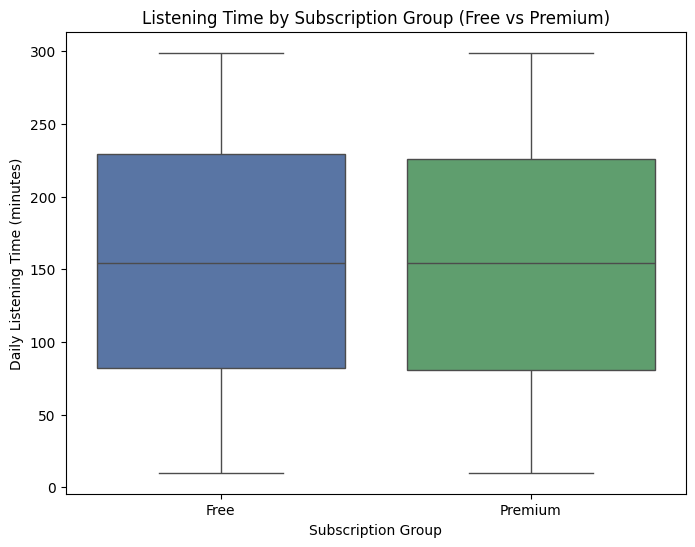

In [ ]:
mapping = {
    "Free": "Free",
    "Premium": "Premium",
    "Family": "Premium",
    "Student": "Premium"
}

df["subscription_group"] = df["subscription_type"].map(mapping)

palette_colors = {
    "Free": "#4C72B0",      # blue
    "Premium": "#55A868"    # green
}

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="subscription_group",
    y="listening_time",
    palette=palette_colors
)

plt.xlabel("Subscription Group")
plt.ylabel("Daily Listening Time (minutes)")
plt.title("Listening Time by Subscription Group (Free vs Premium)")
plt.show()

The plot above shows that Free and Premium users have very similar daily listening times, with nearly identical medians and overlapping interquartile ranges. Both groups also exhibit similar variability, indicating that upgrading to a Premium plan does not strongly change how long users listen per day in this dataset. Overall, listening time appears to be consistent across subscription tiers, suggesting that engagement level is not substantially different between Free and Premium users.

/tmp/ipython-input-3683213920.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'spotify-dataset-for-churn-analysis' dataset.
Dataset loaded successfully!
Total users: 8000
Churned users: 2071 (25.9%)


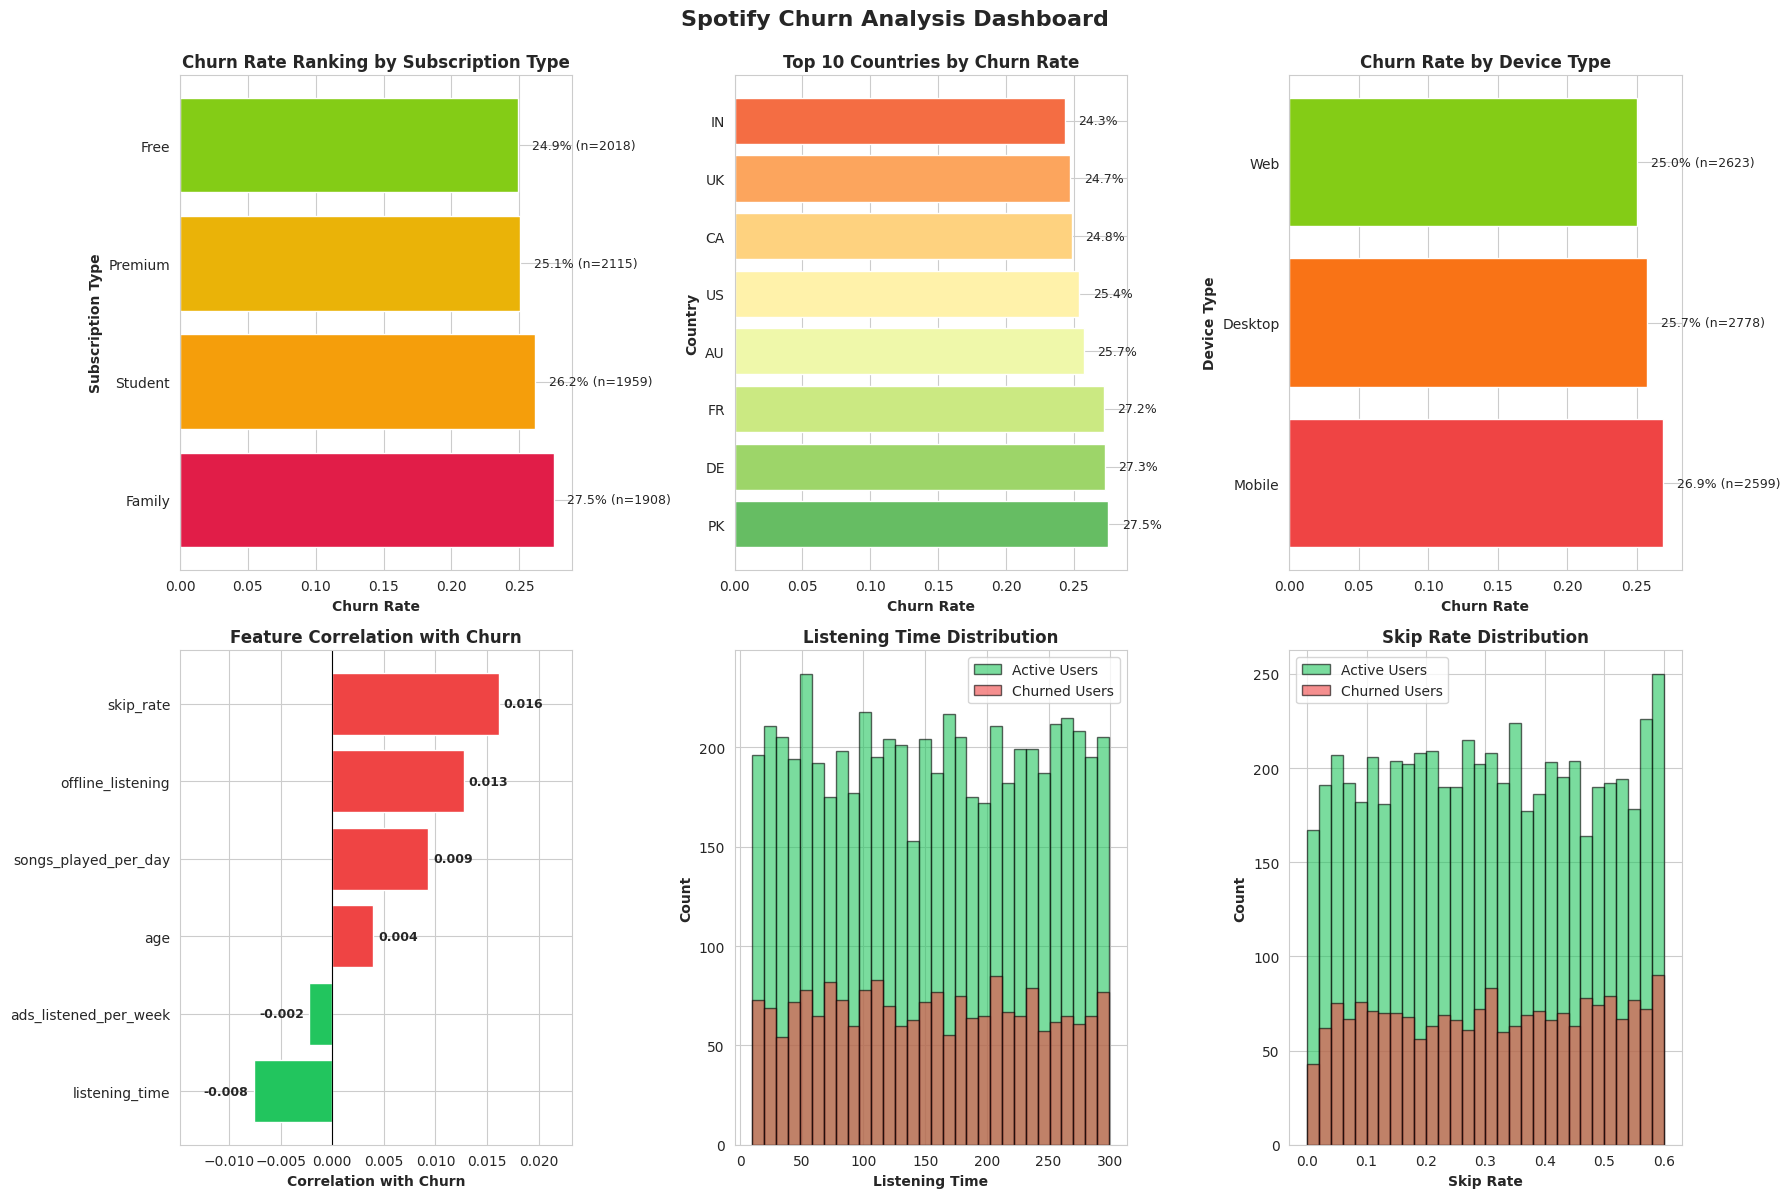

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "spotify_churn_dataset.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "nabihazahid/spotify-dataset-for-churn-analysis",
  file_path,
)

print("Dataset loaded successfully!")
print(f"Total users: {len(df)}")
print(f"Churned users: {df['is_churned'].sum()} ({df['is_churned'].mean()*100:.1f}%)")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 12))  # Made wider to give more space

# Churn Rate by Subscription Type
ax1 = plt.subplot(2, 3, 1)
churn_by_sub = df.groupby('subscription_type')['is_churned'].agg(['mean', 'count']).reset_index()
churn_by_sub.columns = ['subscription_type', 'churn_rate', 'count']
churn_by_sub = churn_by_sub.sort_values('churn_rate', ascending=False)
churn_by_sub['rank'] = range(1, len(churn_by_sub) + 1)

colors = ['#e11d48', '#f59e0b', '#eab308', '#84cc16', '#22c55e'][:len(churn_by_sub)]
bars = ax1.barh(churn_by_sub['subscription_type'], churn_by_sub['churn_rate'], color=colors)
ax1.set_xlabel('Churn Rate', fontweight='bold')
ax1.set_ylabel('Subscription Type', fontweight='bold')
ax1.set_title('Churn Rate Ranking by Subscription Type', fontweight='bold', fontsize=12)
for i, (rate, sub, count) in enumerate(zip(churn_by_sub['churn_rate'],
                                             churn_by_sub['subscription_type'],
                                             churn_by_sub['count'])):
    ax1.text(rate + 0.01, i, f'{rate*100:.1f}% (n={count})', va='center', fontsize=9)

#  Churn Rate by Country
ax2 = plt.subplot(2, 3, 2)
churn_by_country = df.groupby('country')['is_churned'].agg(['mean', 'count']).reset_index()
churn_by_country.columns = ['country', 'churn_rate', 'count']
churn_by_country = churn_by_country.sort_values('churn_rate', ascending=False).head(10)

colors_country = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(churn_by_country)))
ax2.barh(churn_by_country['country'], churn_by_country['churn_rate'], color=colors_country)
ax2.set_xlabel('Churn Rate', fontweight='bold')
ax2.set_ylabel('Country', fontweight='bold')
ax2.set_title('Top 10 Countries by Churn Rate', fontweight='bold', fontsize=12)
for i, rate in enumerate(churn_by_country['churn_rate']):
    ax2.text(rate + 0.01, i, f'{rate*100:.1f}%', va='center', fontsize=9)

# Churn Rate by Device Type
ax3 = plt.subplot(2, 3, 3)
churn_by_device = df.groupby('device_type')['is_churned'].agg(['mean', 'count']).reset_index()
churn_by_device.columns = ['device_type', 'churn_rate', 'count']
churn_by_device = churn_by_device.sort_values('churn_rate', ascending=False)

colors_device = ['#ef4444', '#f97316', '#84cc16'][:len(churn_by_device)]
ax3.barh(churn_by_device['device_type'], churn_by_device['churn_rate'], color=colors_device)
ax3.set_xlabel('Churn Rate', fontweight='bold')
ax3.set_ylabel('Device Type', fontweight='bold')
ax3.set_title('Churn Rate by Device Type', fontweight='bold', fontsize=12)
for i, (rate, count) in enumerate(zip(churn_by_device['churn_rate'], churn_by_device['count'])):
    ax3.text(rate + 0.01, i, f'{rate*100:.1f}% (n={count})', va='center', fontsize=9)

# Feature Correlation with Churn
ax4 = plt.subplot(2, 3, 4)
numeric_features = ['listening_time', 'songs_played_per_day', 'skip_rate',
                    'ads_listened_per_week', 'offline_listening', 'age']
correlations = df[numeric_features + ['is_churned']].corr()['is_churned'].drop('is_churned').sort_values()

colors_corr = ['#22c55e' if x < 0 else '#ef4444' for x in correlations]
ax4.barh(correlations.index, correlations.values, color=colors_corr)
ax4.set_xlabel('Correlation with Churn', fontweight='bold')
ax4.set_title('Feature Correlation with Churn', fontweight='bold', fontsize=12)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Set x-axis limits to give more space for labels
x_min, x_max = correlations.min(), correlations.max()
x_range = x_max - x_min
ax4.set_xlim(x_min - x_range * 0.3, x_max + x_range * 0.3)

# Place labels outside bars with enough space
for i, (val, feature) in enumerate(zip(correlations.values, correlations.index)):
    if val > 0:
        label_x = val + x_range * 0.02  # 2% of range to the right
        alignment = 'left'
    else:
        label_x = val - x_range * 0.02  # 2% of range to the left
        alignment = 'right'

    ax4.text(label_x, i, f'{val:.3f}',
             va='center', ha=alignment, fontsize=9, fontweight='bold')

# Listening Time Distribution
ax5 = plt.subplot(2, 3, 5)
df_churned = df[df['is_churned'] == 1]['listening_time']
df_active = df[df['is_churned'] == 0]['listening_time']
ax5.hist(df_active, bins=30, alpha=0.6, label='Active Users', color='#22c55e', edgecolor='black')
ax5.hist(df_churned, bins=30, alpha=0.6, label='Churned Users', color='#ef4444', edgecolor='black')
ax5.set_xlabel('Listening Time', fontweight='bold')
ax5.set_ylabel('Count', fontweight='bold')
ax5.set_title('Listening Time Distribution', fontweight='bold', fontsize=12)
ax5.legend()

# Skip Rate Distribution
ax6 = plt.subplot(2, 3, 6)
df_churned_skip = df[df['is_churned'] == 1]['skip_rate']
df_active_skip = df[df['is_churned'] == 0]['skip_rate']
ax6.hist(df_active_skip, bins=30, alpha=0.6, label='Active Users', color='#22c55e', edgecolor='black')
ax6.hist(df_churned_skip, bins=30, alpha=0.6, label='Churned Users', color='#ef4444', edgecolor='black')
ax6.set_xlabel('Skip Rate', fontweight='bold')
ax6.set_ylabel('Count', fontweight='bold')
ax6.set_title('Skip Rate Distribution', fontweight='bold', fontsize=12)
ax6.legend()

plt.suptitle('Spotify Churn Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

plt.savefig('spotify_churn_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

